## Importing modules and packages

In [1]:
# Importing packages
import pandas as pd
import numpy  as np
import folium
import os.path
import shapely
import matplotlib.pyplot as plt
from IPython.display import IFrame

# Importing modules
import gr_mapmatch # Contains functions that perform the map matching of roads
import gr_placematch # Contains functions that perform the map matching of places
import gr_utils # Contains useful geometry functions
import gr_plot # Contains plotting routines
import gr_process

/Users/svanwal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Input parameters

In [2]:
trailname = 'gr122' # Name of the hiking trail to be considered (will search for trail.csv or trail.gpx as sources)
d_per_plot = 25 # distance covered by each suplot [km]
d_limit_city = 2500 # minimum distance that the route must traverse through a city for it to be considered [m]

## Loading data

In [3]:
trail = gr_utils.get_gpx(trailname)
data = gr_utils.read_processed(trailname)

Loading trail points from <data_input/gr122.gpx>...
Finished loading.


## Calculations

In [4]:
# Calculating focus point
focus = gr_plot.get_focus(trail)

In [5]:
# Cumulative distance at start and end point of each segment
data = gr_process.calculate_cumulative_distances(data)

In [6]:
# Miscellaneous
d_max = data.tail(1)['d0'].values.tolist()[0] # Total distance of the route
n_points = data.shape[0] # Number of segments in the route
n_plots = int(np.ceil(d_max/(d_per_plot*1000))) # Number of sections plots we will make

In [7]:
# Percentages of paved/traffic/development for the different sections
stats = pd.DataFrame({'i0':[],'i1':[],'dist':[],'perc_p0':[],'perc_p1':[],'perc_p2':[],'perc_t0':[],'perc_t1':[],'perc_t2':[],'perc_d0':[],'perc_d1':[]})
for k in range(n_plots):
    # Indices
    i0 = data[data['d0'].gt(k*d_per_plot*1000)].index[0]
    i1_temp = data[data['d0'].gt((k+1)*d_per_plot*1000)]
    if i1_temp.shape[0]>0:
        i1 = i1_temp.index[0]
    else:
        i1 = n_points
    # Grabbing data subset
    subset = data.loc[i0:i1]
    delta_d = subset['d_cart'].sum()
    # Paved types
    perc_p0 = subset[subset['paved']==0]['d_cart'].sum()/delta_d
    perc_p1 = subset[subset['paved']==1]['d_cart'].sum()/delta_d
    perc_p2 = subset[subset['paved']==2]['d_cart'].sum()/delta_d
    # Traffic types
    perc_t0 = subset[subset['traffic']==0]['d_cart'].sum()/delta_d
    perc_t1 = subset[subset['traffic']==1]['d_cart'].sum()/delta_d
    perc_t2 = subset[subset['traffic']==2]['d_cart'].sum()/delta_d
    # Development types
    perc_d0 = subset[subset['development']==0]['d_cart'].sum()/delta_d
    perc_d1 = subset[subset['development']==1]['d_cart'].sum()/delta_d
    # Merging
    section = {'i0':i0, 'i1':i1, 'dist':delta_d,
               'perc_p0':perc_p0, 'perc_p1':perc_p1, 'perc_p2':perc_p2,
               'perc_t0':perc_t0, 'perc_t1':perc_t1, 'perc_t2':perc_t2,
               'perc_d0':perc_d0, 'perc_d1':perc_d1}
    stats = pd.concat([stats, pd.DataFrame([section])])

In [8]:
# List of main cities traversed by the route
unique_cities = data['city'].unique().tolist() # All cities
selected_cities = []
# Selecting the cities that will be shown
for city in unique_cities:
    subset = data[data['city']==city]
    if subset['d_cart'].sum() > d_limit_city:
        selected_cities.append(city)
# Find the mediam km mark at which each city occurs
city_locations = []
for city in selected_cities:
    subset = data[data['city']==city]
    indices = subset.index.tolist()
    index_median = indices[int(np.round(len(indices)/2))]
    city_locations.append(np.round(data.loc[index_median,'d0'])/1000) # km at which the middle occurrence of that city is

## Plotting

In [9]:
import matplotlib.patheffects as PathEffects

In [10]:
selected_cities[16][0:10]

'Sint-Gorik'

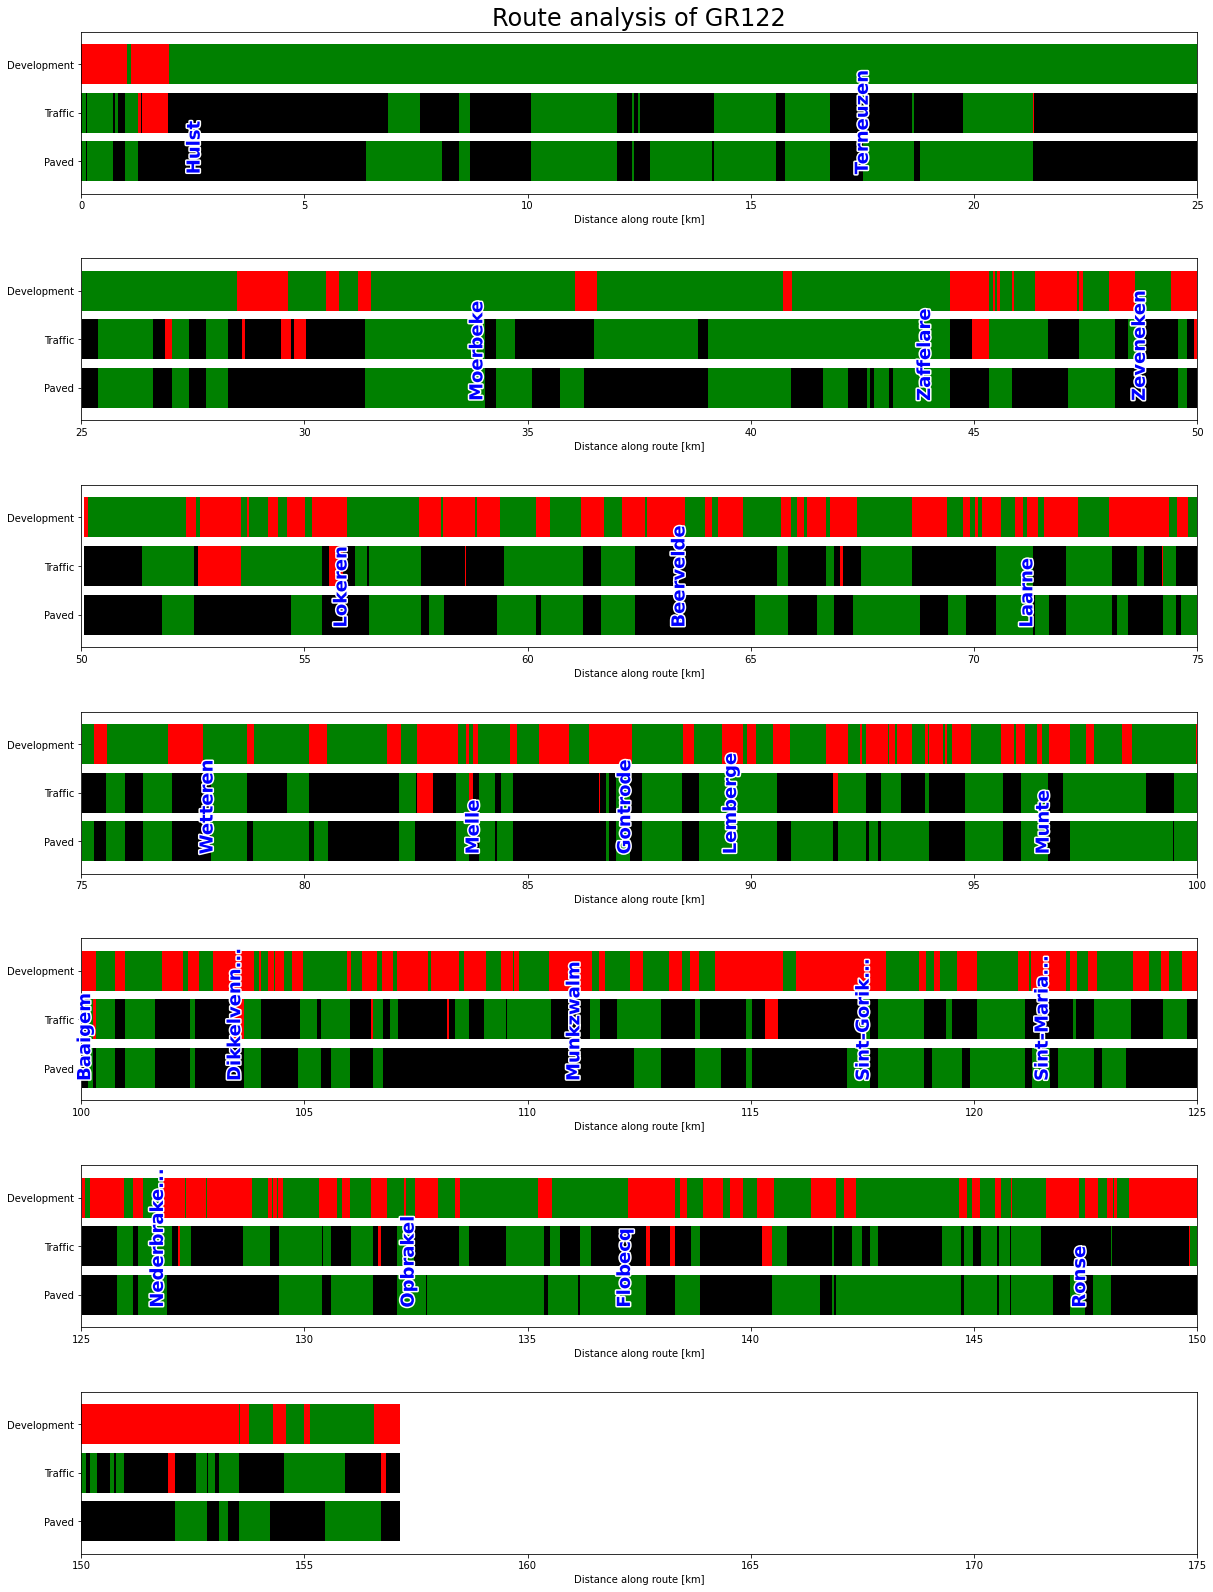

In [11]:
# Sections with paved/traffic/development types
fig, ax = plt.subplots(n_plots,1,figsize=(20,4*n_plots))
plt.rc('font', size=20)
lw = 40
for k in range(n_plots):
    
    # Indices of the subset
    i0 = int(stats.iloc[k]['i0']) # start index
    i1 = int(stats.iloc[k]['i1']) # end index
    
    # Drawing paved/traffic/development types
    for i in range(i0,i1):
        
        # Coordinates
        x = [data.loc[i,'d0']/1000,data.loc[i,'d1']/1000]
        y_paved = [0.85,0.85]
        y_traffic = [1.0,1.0]
        y_development = [1.15,1.15]
        
        # Drawing paved type
        if data.loc[i,'paved']==2: # Draw paved as black
            ax[k].plot(x,y_paved,linewidth=lw,color='black',solid_capstyle='butt',alpha=1)
        else: # Draw unpaved and semi-paved as green
            ax[k].plot(x,y_paved,linewidth=lw,color='green',solid_capstyle='butt',alpha=1)
            
        # Drawing traffic type
        if data.loc[i,'traffic']==0: # Draw slow road as green
            ax[k].plot(x,y_traffic,linewidth=lw,color='green',solid_capstyle='butt',alpha=1)
        elif data.loc[i,'traffic']==1: # Draw normal road as black
            ax[k].plot(x,y_traffic,linewidth=lw,color='black',solid_capstyle='butt',alpha=1)
        else: # Draw busy road as red
            ax[k].plot(x,y_traffic,linewidth=lw,color='red',solid_capstyle='butt',alpha=1)
            
        # Drawing development type
        if data.loc[i,'development']==0: # Draw undeveloped as green
            ax[k].plot(x,y_development,linewidth=lw,color='green',solid_capstyle='butt',alpha=1)
        else: # Draw developed as red
            ax[k].plot(x,y_development,linewidth=lw,color='red',solid_capstyle='butt',alpha=1)
    
    # Writing city names
    for j in range(len(selected_cities)):
        thisd = city_locations[j]
        if thisd>k*d_per_plot and thisd<(k+1)*d_per_plot:
            lmax = 10
            if len(selected_cities[j])>lmax:
                cityname = selected_cities[j][0:lmax] + '...'
            else:
                cityname = selected_cities[j]
            txt = ax[k].text(thisd, 0.81, cityname, rotation=90, fontsize=18, color='blue', wrap=True, fontweight='bold')
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
    
    # Configuring plot
    ax[k].set_xlim(k*d_per_plot, (k+1)*d_per_plot)
    ax[k].set_ylim(0.75, 1.25)
    ax[k].set_yticks([0.85, 1.0, 1.15],labels=['Paved','Traffic','Development'])
    ax[k].set_xlabel('Distance along route [km]')
    if k==0:
        ax[k].set_title(f'Route analysis of {trailname.upper()}')
    
plt.subplots_adjust(hspace=0.4)
plt.show()

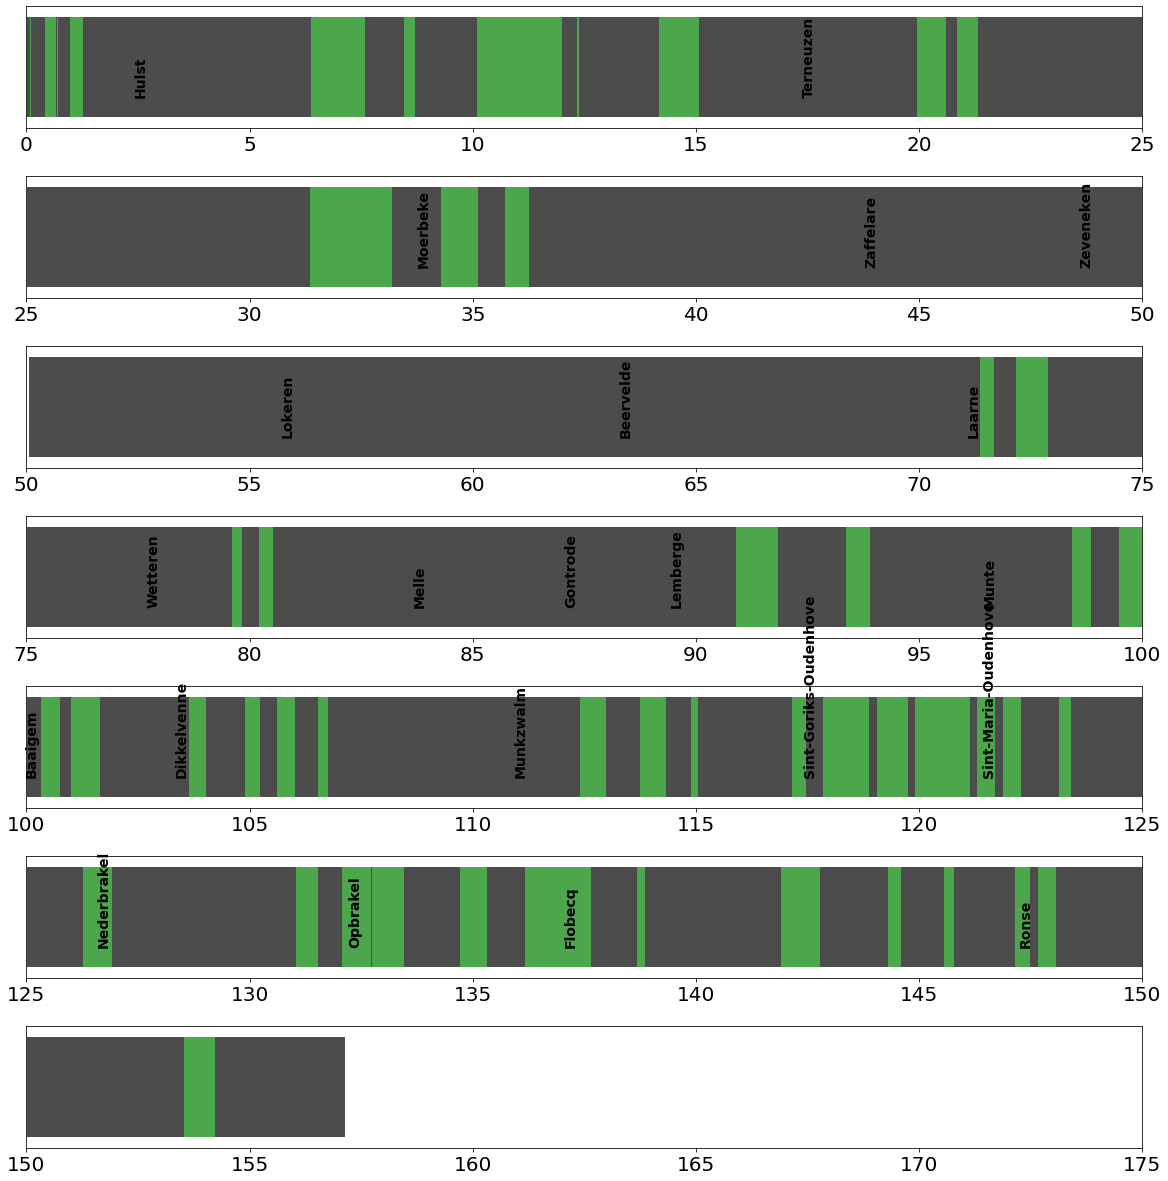

In [12]:
# Sections with paved type only
fig, ax = plt.subplots(n_plots,1,figsize=(20,3*n_plots))
plt.rc('font', size=20)
for k in range(n_plots):
    # Indices of the subset
    i0 = int(stats.iloc[k]['i0']) # start index
    i1 = int(stats.iloc[k]['i1']) # end index
    
    # Drawing paved/traffic/development types
    for i in range(i0,i1):
        # Coordinates
        x = [data.loc[i,'d0']/1000,data.loc[i,'d1']/1000]
        y = [1,1]
        # Drawing paved type
        if data.loc[i,'paved']:
            ax[k].plot(x,y,linewidth=100,color='black',solid_capstyle='butt',alpha=0.7)
        else:
            ax[k].plot(x,y,linewidth=100,color='green',solid_capstyle='butt',alpha=0.7)
    
    # Writing city names
    for j in range(len(selected_cities)):
        thisd = city_locations[j]
        if thisd>k*d_per_plot and thisd<(k+1)*d_per_plot:
            ax[k].text(thisd, 0.995, selected_cities[j], rotation=90, fontsize=14, color='black', wrap=True, fontweight='bold')
    
    # Configuring plot
    ax[k].set_xlim(k*d_per_plot, (k+1)*d_per_plot)
    ax[k].set_ylim(0.99, 1.01)
    ax[k].set_yticks([])
    
plt.subplots_adjust(hspace=0.4)
plt.show()

In [13]:
# Plotting development type
filepath = gr_plot.show_development(data,focus)
IFrame(filepath, width=1000, height=500)

In [14]:
# Plotting traffic type
filepath = gr_plot.show_traffic(data,focus)
IFrame(filepath, width=1000, height=500)

In [19]:
# Plotting paved type with highway/surface/tracktype labels
filepath = gr_plot.show_paved_detail(data,focus)
IFrame(filepath, width=1000, height=500)

In [16]:
# Plotting GR type with highway/surface/tracktype labels
filepath = gr_plot.show_type_detail(data,focus)
IFrame(filepath, width=1000, height=500)

In [17]:
# # Figuring out mean index of each cityname
# vc = data['city'].value_counts()
# nmin = 100 # Minimum number of segments that city must occur in to be considered
# large_vc = vc>nmin
# cities = vc[large_vc].index.tolist() # The cities that occur more than nmin times
# cities_imed = []
# cities_km = []
# for city in cities:
#     mask_city = data['city']==city
#     temp1 = [int(val==True) for val in mask_city.values.tolist()]
#     temp2 = mask_city.index.tolist()
#     temp3 = [x*y for x,y in zip(temp1,temp2)]
#     med = int(sum(temp3)/sum(temp1))
#     cities_imed.append(med)
#     medrow = data.iloc[med]
#     cities_km.append(np.round(medrow['d0'])/1000)
# sort_index = np.argsort(cities_km).tolist()
# final_cities = []
# for i in range(len(cities)):
#     k = sort_index[i]
#     final_cities.append([cities[k], cities_km[k]])

In [18]:
# fig, ax = plt.subplots(n_plots,1,figsize=(20,3*n_plots))
# plt.rc('font', size=20)
# for k in range(n_plots):
#     # Indices of this subset
#     i0 = data[data['d0'].gt(k*d_per_plot*1000)].index[0]
#     i1_temp = data[data['d0'].gt((k+1)*d_per_plot*1000)]
#     if i1_temp.shape[0]>0:
#         i1 = i1_temp.index[0]
#     else:
#         i1 = n_points
#     # Drawing this subset
#     for i in range(i0,i1):
#         x = [data.loc[i,'d0']/1000,data.loc[i,'d1']/1000]
#         y = [1,1]
#         if data.loc[i,'paved']:
#             ax[k].plot(x,y,linewidth=100,color='black',solid_capstyle='butt',alpha=0.7)
#         else:
#             ax[k].plot(x,y,linewidth=100,color='green',solid_capstyle='butt',alpha=0.7)
#     ax[k].set_xlim(k*d_per_plot, (k+1)*d_per_plot)
#     ax[k].set_ylim(0.99, 1.01)
#     ax[k].set_yticks([])
#     for j in range(len(final_cities)):
#         thisd = final_cities[j][1]
#         if thisd>k*d_per_plot and thisd<(k+1)*d_per_plot:
#             ax[k].text(final_cities[j][1], 0.995, final_cities[j][0], rotation=90, fontsize=14, color='black', wrap=True, fontweight='bold')
# plt.subplots_adjust(hspace=0.4)
# plt.show()